In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# set random seeds for reproductibility

torch.manual_seed(42)

In [3]:
# check for Gpu
devices = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {devices}")

Using device: cuda


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fashionmnist


In [5]:
df = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')

In [6]:
df.shape

(60000, 785)

Text(0.5, 0.98, 'First 16 Images ')

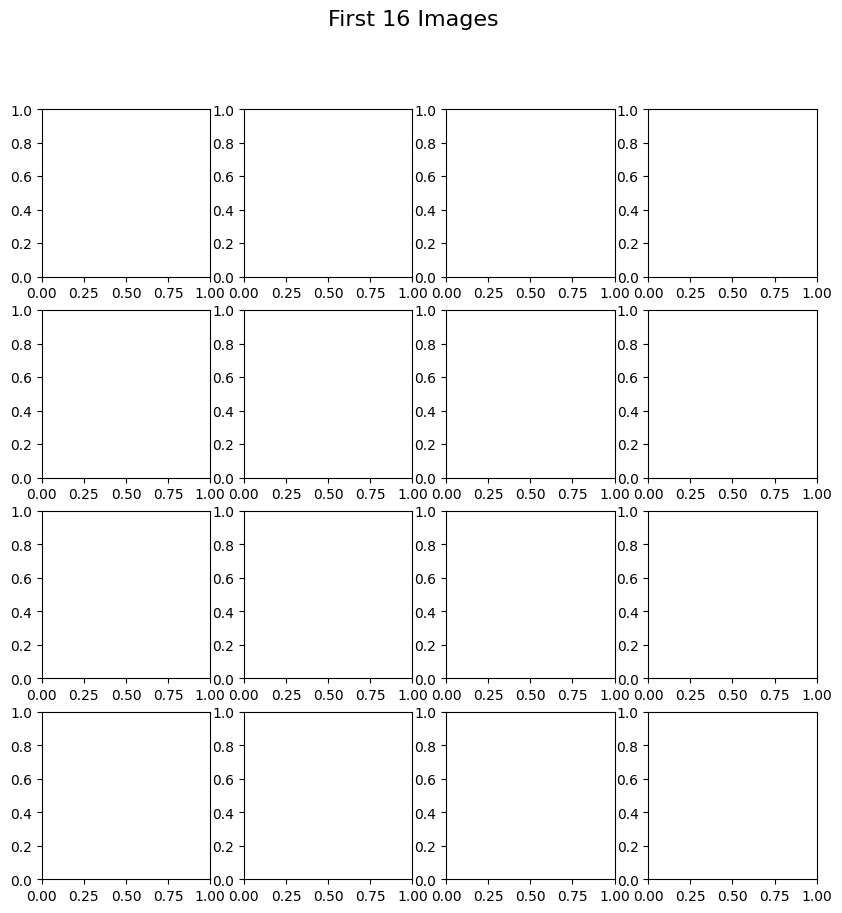

In [7]:
# Create a 4x4 grid of image
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images ", fontsize = 16)


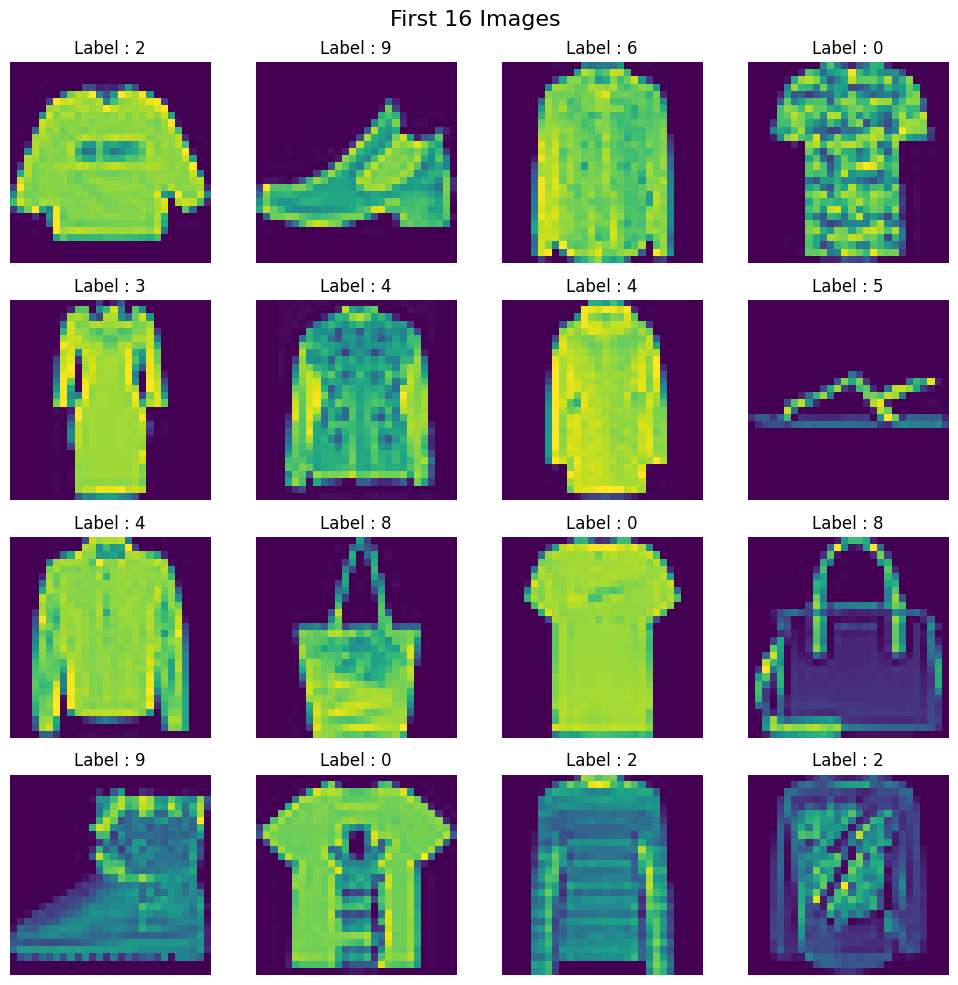

In [8]:
# Create a 4x4 grid of image
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images ", fontsize = 16)

#plot the first 16 images from the data sets
for i, ax in enumerate(axes.flat):
  img = df.iloc[i, 1:].values.reshape(28, 28) #Reahape to 28x28
  ax.imshow(img) # display in gray scale
  ax.axis('off')
  ax.set_title(f"Label : {df.iloc[i, 0]}") #show the label

plt.tight_layout()
plt.show()

In [9]:
# train test split
x = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [11]:
X_train = X_train/255.0
X_test = X_test/255.0

In [12]:
class CustomDatasets(Dataset):
  def __init__(self, features, labels):
    self.features = torch.tensor(features, dtype=torch.float32).reshape(-1,1, 28, 28)
    self.labels = torch.tensor(labels, dtype= torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.labels[index]

In [13]:
train_datasets = CustomDatasets(X_train, y_train)


In [14]:
test_datasets = CustomDatasets(X_test, y_test)

In [15]:
train_loader = DataLoader(train_datasets, batch_size=64, shuffle=True)
test_loader = DataLoader(test_datasets, batch_size=64, shuffle=False)

In [16]:
class MyNN(nn.Module):
    def __init__(self, input_features):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_features, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)

        return x

In [17]:
learning_rate = 0.01
epochs = 100

In [18]:
model = MyNN(1)

model.to(devices)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)


In [20]:
# tranning loop
for epoch in range(epochs):
  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    # move data to gpu
    batch_features, batch_labels = batch_features.to(devices), batch_labels.to(devices)

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


Epoch: 1 , Loss: 0.7845780196587244
Epoch: 2 , Loss: 0.4497225535909335
Epoch: 3 , Loss: 0.37558611087004345
Epoch: 4 , Loss: 0.3360583920677503
Epoch: 5 , Loss: 0.3036180847386519
Epoch: 6 , Loss: 0.2795086266199748
Epoch: 7 , Loss: 0.26077795116106667
Epoch: 8 , Loss: 0.2460301376581192
Epoch: 9 , Loss: 0.23403482057650885
Epoch: 10 , Loss: 0.21698667117208242
Epoch: 11 , Loss: 0.2064068668584029
Epoch: 12 , Loss: 0.1964065708319346
Epoch: 13 , Loss: 0.18786303676168123
Epoch: 14 , Loss: 0.17942557754119237
Epoch: 15 , Loss: 0.17643740937610466
Epoch: 16 , Loss: 0.16491249019404253
Epoch: 17 , Loss: 0.15657737086713314
Epoch: 18 , Loss: 0.1487001716941595
Epoch: 19 , Loss: 0.1416766006735464
Epoch: 20 , Loss: 0.1352291986818115
Epoch: 21 , Loss: 0.12768317461262146
Epoch: 22 , Loss: 0.121304278348883
Epoch: 23 , Loss: 0.11487610258162022
Epoch: 24 , Loss: 0.10879850109666586
Epoch: 25 , Loss: 0.10880307638520996
Epoch: 26 , Loss: 0.0999216195307672
Epoch: 27 , Loss: 0.096824079430351

In [21]:
model.eval()

MyNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [23]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(devices), batch_labels.to(devices)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.922


In [25]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(devices), batch_labels.to(devices)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

1.0
